# PCA

In [1]:
from src.utils.check_mps_device import check_mps_device
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from src.utils.data_loading import load_data
from src.utils.filtering import filter_data
from src.utils.label_encoding import label_encode_column

# Check if PyTorch Multi-Process Service (MPS) is available (GPU)
check_mps_device()

tensor([1.], device='mps:0')


In [2]:
selected_features = [
    "geocentric_latitude",  # Latitude of conjunction point [deg]
    "c_sigma_rdot",  # covariance; radial velocity standard deviation (sigma) of chaser [m/s]
    "c_obs_used",  # number of observations used for orbit determination (per CDM) of chaser
    "c_time_lastob_start",
    # start of the time in days of the last accepted observation used in the orbit determination of chaser
    "c_time_lastob_end",
    # end of the time interval in days of the last accepted observation used in the orbit determination of chaser
    "mahalanobis_distance",  # The distance between the chaser and target
    "miss_distance",  # relative position between chaser & target at tca [m
    "time_to_tca",  # Time interval between CDM creation and time-of-closest approach [days]
    "t_cndot_r",
    # covariance; correlation of normal (cross-track) velocity vs radial position of chaser
    "c_cr_area_over_mass",
    # solar radiation coefficient . A/m (ballistic coefficient equivalent) of chaser
    "max_risk_estimate",  # maximum collision probability obtained by scaling combined covariance
    "c_span",  # size used by the collision risk computation algorithm of chaser [m]
    "max_risk_scaling",  # scaling factor used to compute maximum collision probability
    "t_rcs_estimate",  # radar cross-sectional area [m2m2] of target
    "c_sigma_t",
    # covariance; transverse (along-track) position standard deviation (sigma) of chaser [m]
    "c_obs_available",  # number of observations available for orbit determination (per CDM),
    "risk",
]

## Feature Scaling:

In [3]:
# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)
df_filtered.dropna(axis=0, how="any", inplace=True)
# Label encode the categorical column "c_object_type"
label_encode_column(df_filtered, "c_object_type")

df_new = df_filtered[selected_features]

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


In [4]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features
numerical_features = df_new.select_dtypes(include=["float64"]).columns

# Initialize the StandardScaler
scaler = StandardScaler()
df_new_scaled = df_new.copy()
# Scale numerical features
df_new_scaled[numerical_features] = scaler.fit_transform(
    df_new_scaled[numerical_features]
)

# Optionally, you can display the summary statistics of the scaled features
# print("Summary statistics after scaling:")
# print(df_new_scaled[numerical_features].describe())

### Using the already selected 17 features

Selected Features:
['geocentric_latitude', 'c_sigma_rdot', 'c_obs_used', 'c_time_lastob_start', 'c_time_lastob_end', 'mahalanobis_distance', 'miss_distance', 'time_to_tca', 't_cndot_r', 'c_cr_area_over_mass', 'max_risk_estimate', 'c_span', 'max_risk_scaling', 't_rcs_estimate', 'c_sigma_t', 'c_obs_available', 'risk']


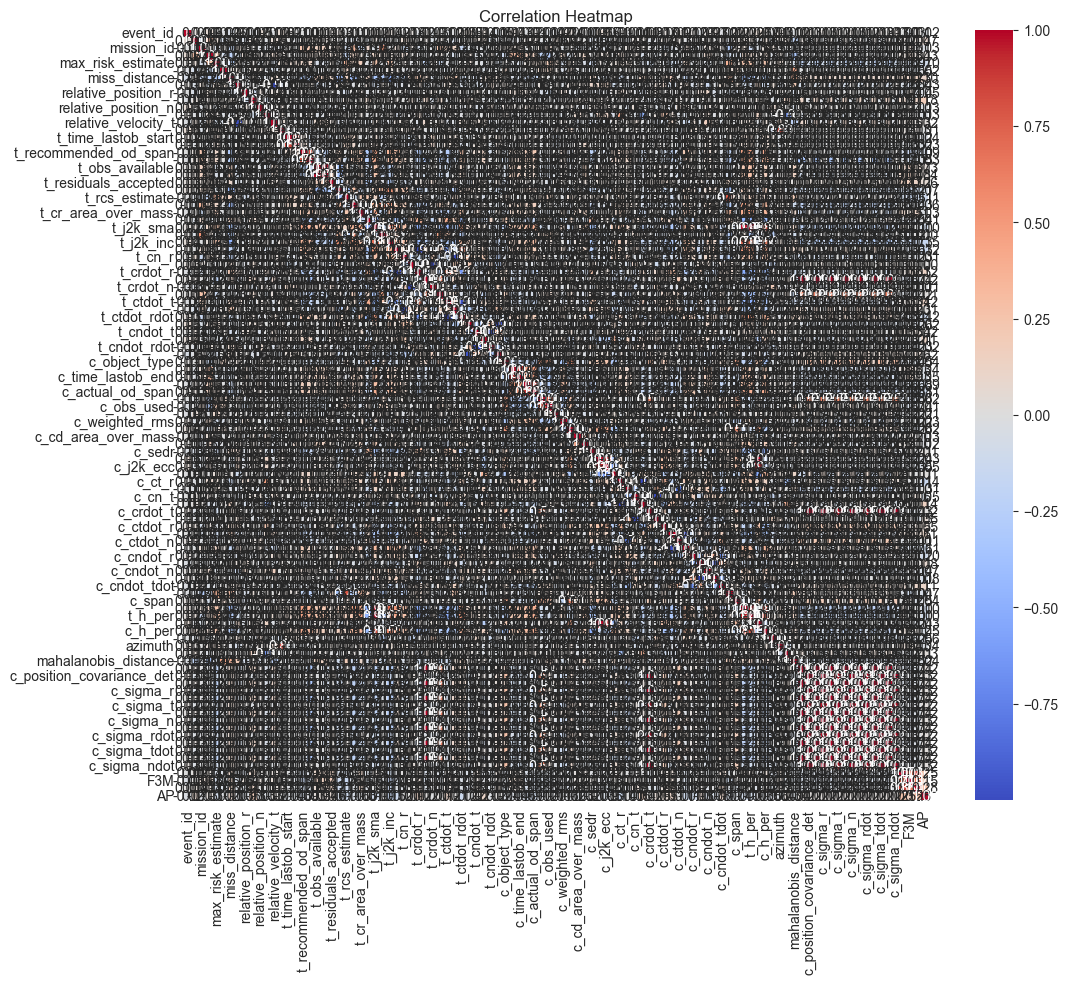

Explained Variance Ratio:
[9.27993846e-01 7.16684522e-02 3.29826970e-04 2.06453053e-06
 5.97688403e-07 5.17413445e-07 3.38135945e-07 2.72676642e-07
 2.10394764e-07 1.96864864e-07 1.91064771e-07 1.84320644e-07
 1.70324485e-07 1.57241565e-07 1.47513784e-07 1.42202259e-07
 1.39022279e-07]


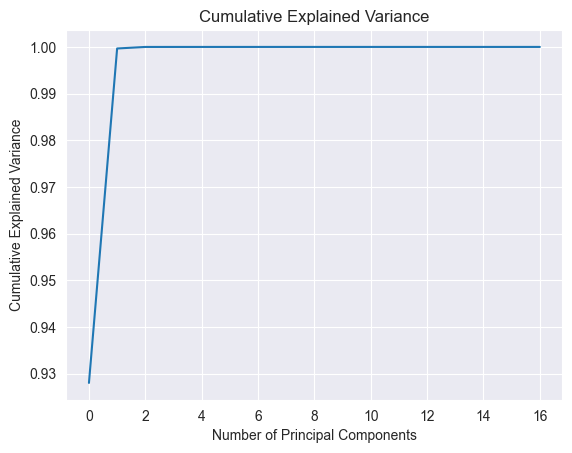

In [5]:
from sklearn.decomposition import PCA

# a. Confirm Relevant Features:
# Display the selected 17 features
print("Selected Features:")
print(selected_features)

# Verify that these features align with the problem statement and provide meaningful information

# b. Correlation Analysis:
# Check for correlations between features
correlation_matrix = df_new_scaled.corr()

# Plot a heatmap for correlation visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# c. Dimensionality Reduction (if needed) using PCA:
# Assuming n_components is the number of principal components you want to keep
n_components = len(selected_features)  # Adjust as needed

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit and transform the data
principal_components = pca.fit_transform(df_new_scaled)

# Create a DataFrame with the principal components
columns_pca = [f"PC{i + 1}" for i in range(n_components)]
df_pca = pd.DataFrame(data=principal_components, columns=columns_pca)

# Display the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Optionally, you can plot the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_explained_variance)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

# Merge the principal components with the original DataFrame if needed
df_filtered_pca = pd.concat([df_new_scaled, df_pca], axis=1)

# Optionally, you can further analyze the importance of each feature in the principal components
feature_importance_pca = pca.components_

In [6]:
# Create a DataFrame with the principal components
columns_pca = [f"PC{i + 1}" for i in range(n_components)]
df_pca = pd.DataFrame(data=principal_components, columns=columns_pca)

# Classify 'risk' feature based on the condition
df_pca["risk_classified"] = df_new["risk"].apply(lambda x: 1 if x >= -6 else 0)

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    df_pca,
    x="PC1",
    y="PC2",
    z="PC3",
    color="risk_classified",
    color_discrete_map={0: "blue", 1: "red"},
)
# Customize the layout
fig.update_layout(
    title="3D Scatter Plot of Data Points in Principal Component Space",
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3",
    ),
)

fig.update_traces(marker=dict(size=4))
# Show the plot
fig.show()